In [1]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from torchmetrics.functional.multimodal import clip_score
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
import numpy as np
import torch
import os

2025-04-20 08:29:22.860952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745137763.054722      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745137763.108030      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# 1. Read prompts
def read_prompts(files_dir):
    prompts = []
    
    # Sort files numerically based on filename (assuming format like 00001.txt)
    sorted_files = sorted(
        [file for file in os.listdir(files_dir) if file.endswith(".txt")],
        key=lambda x: int(os.path.splitext(x)[0])
    )

    for file in sorted_files:
        file_path = os.path.join(files_dir, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            if len(lines) >= 2:
                positive = lines[0].strip()
                negative = lines[1].strip()
                prompt = f'Positive prompt: {positive}\nNegative prompt: {negative}\n'
                print(f"\nFrom file: {file}\n{prompt}")
                prompts.append(prompt)
            else:
                print(f"\nFile {file} does not contain at least two lines.")
    return prompts

# Example usage:
read_prompts('/kaggle/input/generated-images/prompts')
print()


From file: 00002.txt
Positive prompt: A mother fanning her sleeping child in a dark room, ceiling fan above still, sweat glistening like light on her forehead
Negative prompt: air conditioning, modern lighting, futuristic decor


From file: 00003.txt
Positive prompt: A chaiwala pouring tea under a single emergency bulb, his face split between light and shadow
Negative prompt: barista, cafe, clean western street


From file: 00004.txt
Positive prompt: A father fixing a broken fan under flashlight, daughter asleep beside a melted ice bottle
Negative prompt: high-tech tools, neat workspace, AC


From file: 00005.txt
Positive prompt: A young girl drawing flowers with chalk on a cracked wall, the street pitch black except for her glowing eyes
Negative prompt: perfect wall, playground, digital art


From file: 00006.txt
Positive prompt: An old poet scribbling verses in a notebook, surrounded by dried rose petals and a flickering lantern
Negative prompt: typewriter, neon, coffee shop


From 

In [7]:
# 2. Read images
def read_images(files_dir):
    images = []
    # Gather and sort image files numerically by filename (without extension)
    valid_exts = (".png", ".jpeg", ".jpg", ".webp")
    sorted_files = sorted(
        [file for file in os.listdir(files_dir) if file.lower().endswith(valid_exts)],
        key=lambda x: int(os.path.splitext(x)[0])
    )

    for file in sorted_files:
        file_path = os.path.join(files_dir, file)
        try:
            image = Image.open(file_path).convert('RGB')
            image = image.resize((512, 512))
            image_array = np.array(image)
            reshaped_image = image_array.reshape(1, *image_array.shape)
            print(f"\nFrom file: {file}\nShape: {reshaped_image.shape}")
            images.append(reshaped_image)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return images

read_images('/kaggle/input/generated-images/images')
print()


From file: 00002.webp
Shape: (1, 512, 512, 3)

From file: 00003.webp
Shape: (1, 512, 512, 3)

From file: 00004.webp
Shape: (1, 512, 512, 3)

From file: 00005.webp
Shape: (1, 512, 512, 3)

From file: 00006.webp
Shape: (1, 512, 512, 3)

From file: 00007.webp
Shape: (1, 512, 512, 3)

From file: 00008.webp
Shape: (1, 512, 512, 3)

From file: 00009.webp
Shape: (1, 512, 512, 3)

From file: 00010.webp
Shape: (1, 512, 512, 3)

From file: 00011.webp
Shape: (1, 512, 512, 3)

From file: 00012.webp
Shape: (1, 512, 512, 3)

From file: 00013.webp
Shape: (1, 512, 512, 3)

From file: 00014.webp
Shape: (1, 512, 512, 3)

From file: 00015.webp
Shape: (1, 512, 512, 3)

From file: 00016.webp
Shape: (1, 512, 512, 3)

From file: 00017.webp
Shape: (1, 512, 512, 3)

From file: 00018.webp
Shape: (1, 512, 512, 3)

From file: 00019.webp
Shape: (1, 512, 512, 3)

From file: 00020.webp
Shape: (1, 512, 512, 3)

From file: 00021.webp
Shape: (1, 512, 512, 3)

From file: 00022.webp
Shape: (1, 512, 512, 3)

From file: 0

In [9]:
# Load models
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")
sbert = SentenceTransformer("all-MiniLM-L6-v2")
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [21]:
# 3. CLIP score setup
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

# 4. CLIP calculation function
def calculate_clip_scores(images, prompts):
    images_int = (images * 255).astype("uint8")
    torch_imgs = torch.from_numpy(images_int).permute(2, 0, 1)
    scores = clip_score_fn(torch_imgs, prompts).detach().cpu().numpy()
    return np.round(scores, 4)

In [22]:
images = read_images('/kaggle/input/generated-images/images')
prompts = read_prompts('/kaggle/input/generated-images/prompts')


From file: 00002.webp
Shape: (1, 512, 512, 3)

From file: 00003.webp
Shape: (1, 512, 512, 3)

From file: 00004.webp
Shape: (1, 512, 512, 3)

From file: 00005.webp
Shape: (1, 512, 512, 3)

From file: 00006.webp
Shape: (1, 512, 512, 3)

From file: 00007.webp
Shape: (1, 512, 512, 3)

From file: 00008.webp
Shape: (1, 512, 512, 3)

From file: 00009.webp
Shape: (1, 512, 512, 3)

From file: 00010.webp
Shape: (1, 512, 512, 3)

From file: 00011.webp
Shape: (1, 512, 512, 3)

From file: 00012.webp
Shape: (1, 512, 512, 3)

From file: 00013.webp
Shape: (1, 512, 512, 3)

From file: 00014.webp
Shape: (1, 512, 512, 3)

From file: 00015.webp
Shape: (1, 512, 512, 3)

From file: 00016.webp
Shape: (1, 512, 512, 3)

From file: 00017.webp
Shape: (1, 512, 512, 3)

From file: 00018.webp
Shape: (1, 512, 512, 3)

From file: 00019.webp
Shape: (1, 512, 512, 3)

From file: 00020.webp
Shape: (1, 512, 512, 3)

From file: 00021.webp
Shape: (1, 512, 512, 3)

From file: 00022.webp
Shape: (1, 512, 512, 3)

From file: 0


🔎 Image 1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A mother fanning her sleeping child in a dark room, ceiling fan above still, sweat glistening like light on her forehead
Negative prompt: air conditioning, modern lighting, futuristic decor

🧠 BLIP Generated: a woman holding a fan while holding her child
CLIP Score: 38.42789840698242
BLIP Similarity Score: 0.4021
------------------------------------------------------------

🔎 Image 2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A chaiwala pouring tea under a single emergency bulb, his face split between light and shadow
Negative prompt: barista, cafe, clean western street

🧠 BLIP Generated: a man is holding a teapot and a light bulb
CLIP Score: 34.49150085449219
BLIP Similarity Score: 0.4331
------------------------------------------------------------

🔎 Image 3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

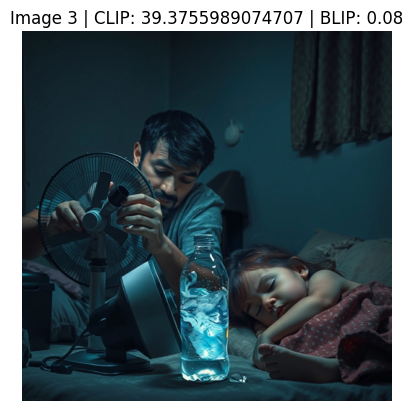

📝 Prompt: Positive prompt: A father fixing a broken fan under flashlight, daughter asleep beside a melted ice bottle
Negative prompt: high-tech tools, neat workspace, AC

🧠 BLIP Generated: a man and a child are sleeping in bed
CLIP Score: 39.3755989074707
BLIP Similarity Score: 0.08
------------------------------------------------------------

🔎 Image 4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A young girl drawing flowers with chalk on a cracked wall, the street pitch black except for her glowing eyes
Negative prompt: perfect wall, playground, digital art

🧠 BLIP Generated: a young girl drawing on a wall at night
CLIP Score: 39.96120071411133
BLIP Similarity Score: 0.5784
------------------------------------------------------------

🔎 Image 5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

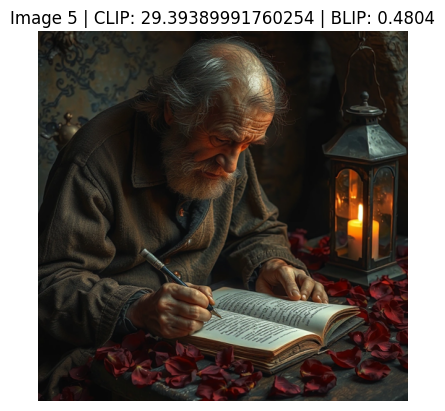

📝 Prompt: Positive prompt: An old poet scribbling verses in a notebook, surrounded by dried rose petals and a flickering lantern
Negative prompt: typewriter, neon, coffee shop

🧠 BLIP Generated: an old man is writing in a book with rose petals around him
CLIP Score: 29.39389991760254
BLIP Similarity Score: 0.4804
------------------------------------------------------------

🔎 Image 6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A young woman pouring chai in the courtyard at midnight, her face softly lit by a flame, lost in memory
Negative prompt: kitchen stove, daylight, overhead bulb

🧠 BLIP Generated: a woman pouring tea into a pot
CLIP Score: 37.1265983581543
BLIP Similarity Score: 0.3351
------------------------------------------------------------

🔎 Image 7


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A man holding a lantern in one hand and prayer beads in the other, standing at the edge of his rooftop, eyes skyward
Negative prompt: mosque lights, crowd, modern lantern

🧠 BLIP Generated: a man holding a lantern on a rooftop
CLIP Score: 37.406898498535156
BLIP Similarity Score: 0.5804
------------------------------------------------------------

🔎 Image 8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A child tracing patterns on the floor with candle wax, his mind drifting into imaginary lands
Negative prompt: cluttered room, LED, toys

🧠 BLIP Generated: a young boy sitting on the floor with a candle
CLIP Score: 31.615400314331055
BLIP Similarity Score: 0.45
------------------------------------------------------------

🔎 Image 9


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: An elderly man lighting a candle at a family photo, the room around him silent and dust-laden
Negative prompt: polished interior, modern furniture

🧠 BLIP Generated: a man holding a candle
CLIP Score: 33.15999984741211
BLIP Similarity Score: 0.463
------------------------------------------------------------

🔎 Image 10


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A boy looking into a lantern as if seeking answers inside it, his eyes reflecting the flame like distant suns
Negative prompt: fire hazard, electricity, superhero vibe

🧠 BLIP Generated: a young boy holding an old lantern in the dark
CLIP Score: 33.80929946899414
BLIP Similarity Score: 0.5086
------------------------------------------------------------

🔎 Image 11


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A teacher writing Urdu poetry on a chalkboard alone at night, oil lamp balanced on her desk
Negative prompt: fluorescent tube, whiteboard, tech

🧠 BLIP Generated: a woman writing on a blackboard with a candle
CLIP Score: 36.46160125732422
BLIP Similarity Score: 0.4732
------------------------------------------------------------

🔎 Image 12


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A man staring into an empty teacup, candle beside it casting rings of light like time loops on the table
Negative prompt: mug, branded cup, table clutter

🧠 BLIP Generated: a man is looking at a cup with a candle in the dark
CLIP Score: 33.53779983520508
BLIP Similarity Score: 0.5325
------------------------------------------------------------

🔎 Image 13


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A man gazing at a moth circling a flame, eyes wide with wonder and fear
Negative prompt: clean surroundings, sunlight, bug zapper

🧠 BLIP Generated: a man with a butterfly on his head
CLIP Score: 35.55939865112305
BLIP Similarity Score: 0.4285
------------------------------------------------------------

🔎 Image 14


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A woman writing a letter by oil lamp, each word bleeding slowly into the page like a memory
Negative prompt: keyboard, phone, white paper

🧠 BLIP Generated: a woman writing in a book with a candle in the background
CLIP Score: 30.614500045776367
BLIP Similarity Score: 0.4664
------------------------------------------------------------

🔎 Image 15


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A bearded man looking at the stars while holding a clay lantern, wind playing with the flame
Negative prompt: modern torch, telescope, concrete setting

🧠 BLIP Generated: a man with a beard holding a lantern in the dark
CLIP Score: 40.712501525878906
BLIP Similarity Score: 0.5314
------------------------------------------------------------

🔎 Image 16


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: Close-up of a girl’s face lit only by a candle, her eyes reflecting flame, lost in silent thought
Negative prompt: makeup, beauty lighting, artificial glow

🧠 BLIP Generated: a young girl is looking at a lit candle
CLIP Score: 32.540199279785156
BLIP Similarity Score: 0.4833
------------------------------------------------------------

🔎 Image 17


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

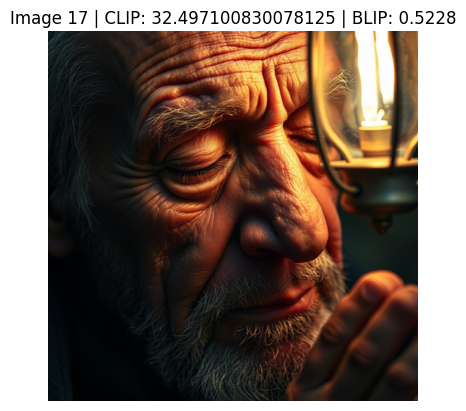

📝 Prompt: Positive prompt: Extreme close-up of an elderly man’s wrinkled face, eyes closed in prayer, flickering lantern casting soft shadows on his features
Negative prompt: modern face lighting, flash photography

🧠 BLIP Generated: an old man with a beard looking at a light bulb
CLIP Score: 32.497100830078125
BLIP Similarity Score: 0.5228
------------------------------------------------------------

🔎 Image 18


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

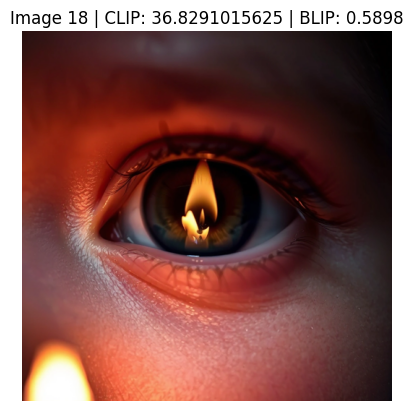

📝 Prompt: Positive prompt: Macro shot of a child’s eye reflecting a candle’s flame, the pupil trembling as if holding a memory
Negative prompt: animation style, sci-fi glow, glasses

🧠 BLIP Generated: a close up of a child's eye with a candle in it
CLIP Score: 36.8291015625
BLIP Similarity Score: 0.5898
------------------------------------------------------------

🔎 Image 19


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: Tight crop of a man’s beard and lips as he quietly recites a verse to himself, candlelight trembling on his breath
Negative prompt: microphone, perfect studio audio look

🧠 BLIP Generated: a man with a beard and a candle in his hand
CLIP Score: 33.166500091552734
BLIP Similarity Score: 0.4235
------------------------------------------------------------

🔎 Image 20


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: Close-up of a girl’s face partially covered by a dupatta, her wide, dim-lit eyes peering into the flame of a lantern she cradles like a secret
Negative prompt: fashion photo, bokeh effects, smile

🧠 BLIP Generated: a young girl with a lantern in her hand
CLIP Score: 37.23780059814453
BLIP Similarity Score: 0.4199
------------------------------------------------------------

🔎 Image 21


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

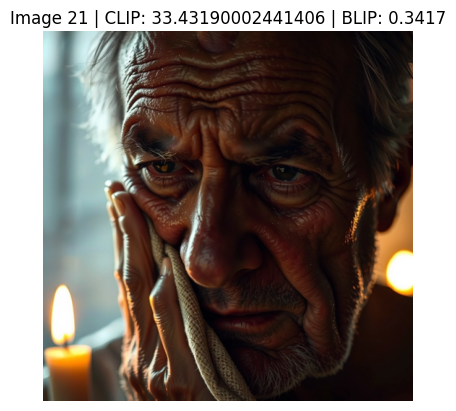

📝 Prompt: Positive prompt: Tight facial portrait of an old man wiping his face with a wet cloth, jaw tense, candlelight shimmering across sweat
Negative prompt: glamour shot, clean-shaven, daylight

🧠 BLIP Generated: an old man with a candle in his hand
CLIP Score: 33.43190002441406
BLIP Similarity Score: 0.3417
------------------------------------------------------------

🔎 Image 22


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

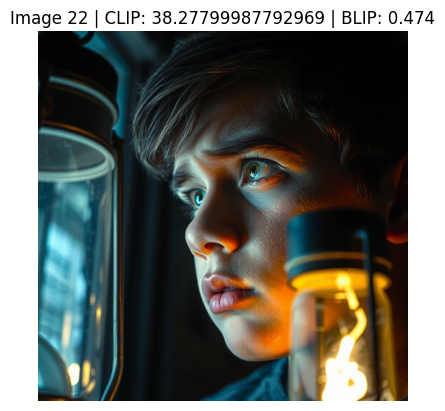

📝 Prompt: Positive prompt: Close-up of a teenage boy’s anxious face lit by a lantern, his brows tense, staring toward the open window as if listening for a generator hum
Negative prompt: daylight, electricity poles, fan

🧠 BLIP Generated: a young boy looking at a light bulb
CLIP Score: 38.27799987792969
BLIP Similarity Score: 0.474
------------------------------------------------------------

🔎 Image 23


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: A woman’s tired face close-up, resting her head on her hand, candle flickering beside her, her eyes fixed on the clock in the dark
Negative prompt: LED clock, digital watch, bright room

🧠 BLIP Generated: a woman with a candle in front of a clock
CLIP Score: 36.15629959106445
BLIP Similarity Score: 0.4938
------------------------------------------------------------

🔎 Image 24


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

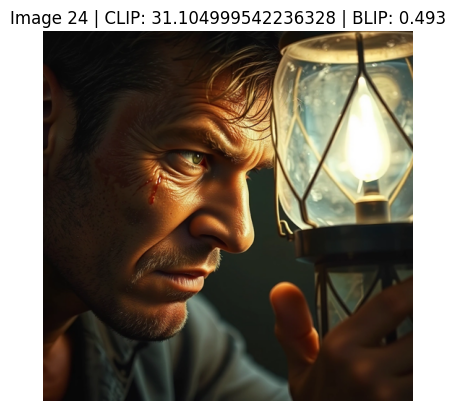

📝 Prompt: Positive prompt: Portrait of a man with sweat trickling down his face, jaw clenched, leaning close to a lantern like it holds answers
Negative prompt: fan, luxury interior, clean forehead

🧠 BLIP Generated: a man holding a lantern in front of his face
CLIP Score: 31.104999542236328
BLIP Similarity Score: 0.493
------------------------------------------------------------

🔎 Image 25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

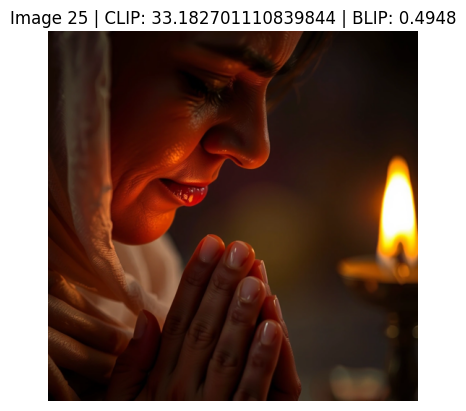

📝 Prompt: Positive prompt: Close-up of a woman praying under her breath, hands cupped under her chin, tears reflecting the light of a diya
Negative prompt: mosque light, crowd, artificial lighting

🧠 BLIP Generated: a woman in a headscarf is praying with her hands
CLIP Score: 33.182701110839844
BLIP Similarity Score: 0.4948
------------------------------------------------------------

🔎 Image 26


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Prompt: Positive prompt: Close-up portrait of a boy peeking through window grills, candle behind him casting his face into dramatic half-light, eyes full of hope
Negative prompt: city lights, reflection from screen

🧠 BLIP Generated: a young boy is looking through a cage with candles
CLIP Score: 33.39419937133789
BLIP Similarity Score: 0.4341
------------------------------------------------------------

🔎 Image 27


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

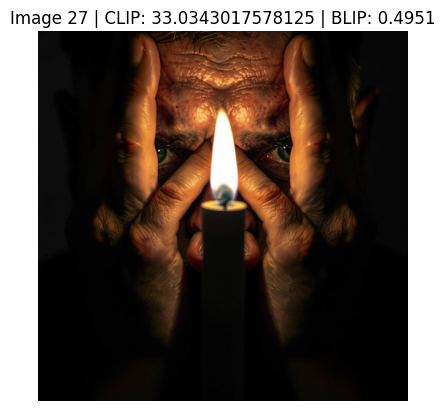

📝 Prompt: Positive prompt: Macro close-up of a man’s face covered in frustration, hands over his eyes, single candlelight casting his fingers into long shadows
Negative prompt: daylight, crowd, fluorescent bulb

🧠 BLIP Generated: a man with his hands over his face and a lit candle
CLIP Score: 33.0343017578125
BLIP Similarity Score: 0.4951
------------------------------------------------------------

🔎 Image 28


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

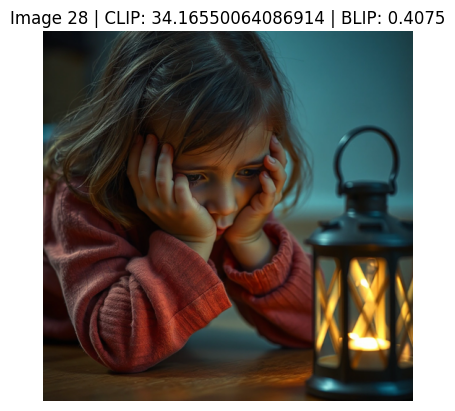

📝 Prompt: Positive prompt: Tight shot of a young girl’s hands holding her face, staring at a lantern on the floor, exhaustion visible in her body language
Negative prompt: posing, joy, fashion style

🧠 BLIP Generated: a little girl looking at a lantern
CLIP Score: 34.16550064086914
BLIP Similarity Score: 0.4075
------------------------------------------------------------

🔎 Image 29


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

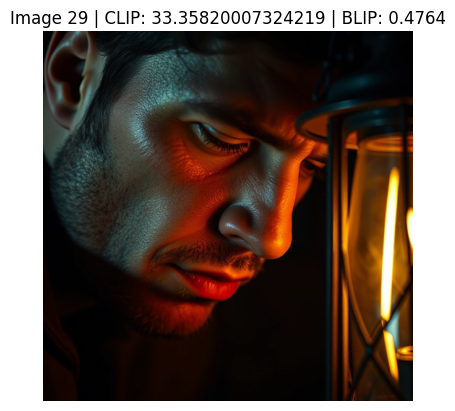

📝 Prompt: Positive prompt: Close-up of a man’s face leaning toward a flickering lantern, his face half-lit, lips silently counting seconds
Negative prompt: watch, digital clock, noisy background

🧠 BLIP Generated: a man is looking at a lantern
CLIP Score: 33.35820007324219
BLIP Similarity Score: 0.4764
------------------------------------------------------------


In [25]:

clip_scores = []
blip_scores = []
generated_captions = []

images_norm = np.array(images) / 255.0  # Normalize for display
images_norm = np.squeeze(images_norm)

for idx, (img, prompt) in enumerate(zip(images_norm, prompts)):
    print(f"\n🔎 Image {idx+1}")
    # ---- CLIP ----
    clip_score_val = calculate_clip_scores(img, prompt)
    clip_scores.append(clip_score_val)

    # ---- BLIP ----
    pil_img = Image.fromarray((img * 255).astype("uint8"))
    inputs = processor(images=pil_img, return_tensors="pt").to("cuda", torch.float16)
    generated_ids = model.generate(**inputs)
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    generated_captions.append(caption)

    embeddings = sbert.encode([prompt, caption], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    blip_scores.append(similarity)

    # ---- Display ----
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title(f"Image {idx+1} | CLIP: {clip_score_val} | BLIP: {round(similarity, 4)}")
    plt.show()

    print(f"📝 Prompt: {prompt}")
    print(f"🧠 BLIP Generated: {caption}")
    print(f"CLIP Score: {clip_score_val}")
    print(f"BLIP Similarity Score: {round(similarity, 4)}")
    print('-' * 60)


🔥 Average CLIP Score: 34.8286018371582
🧠 Average BLIP Similarity Score: 0.4584


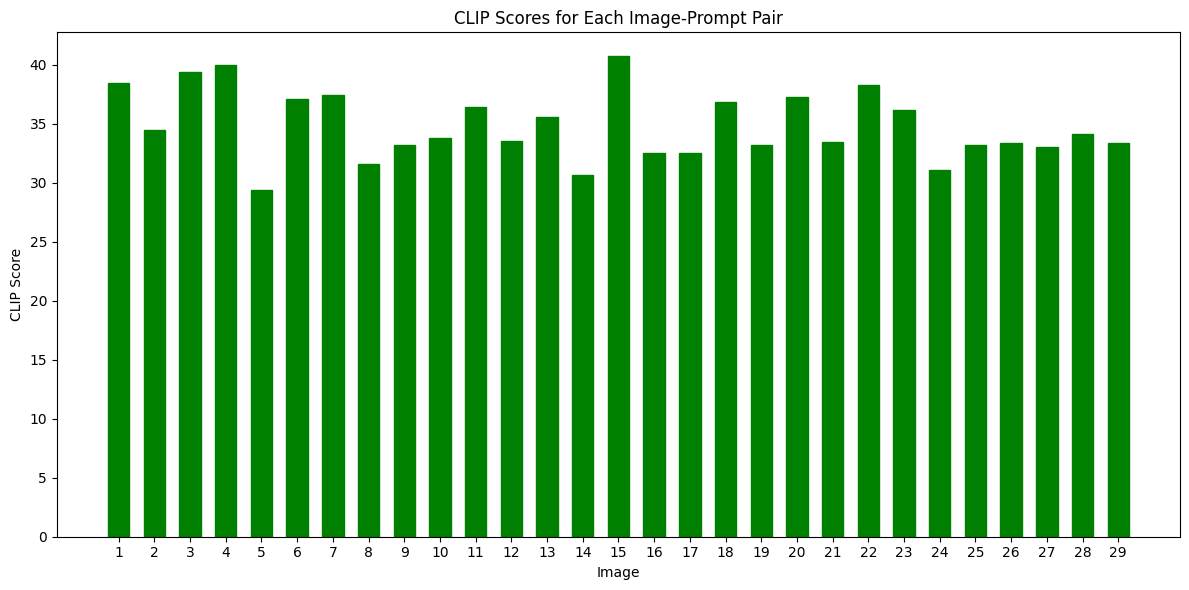

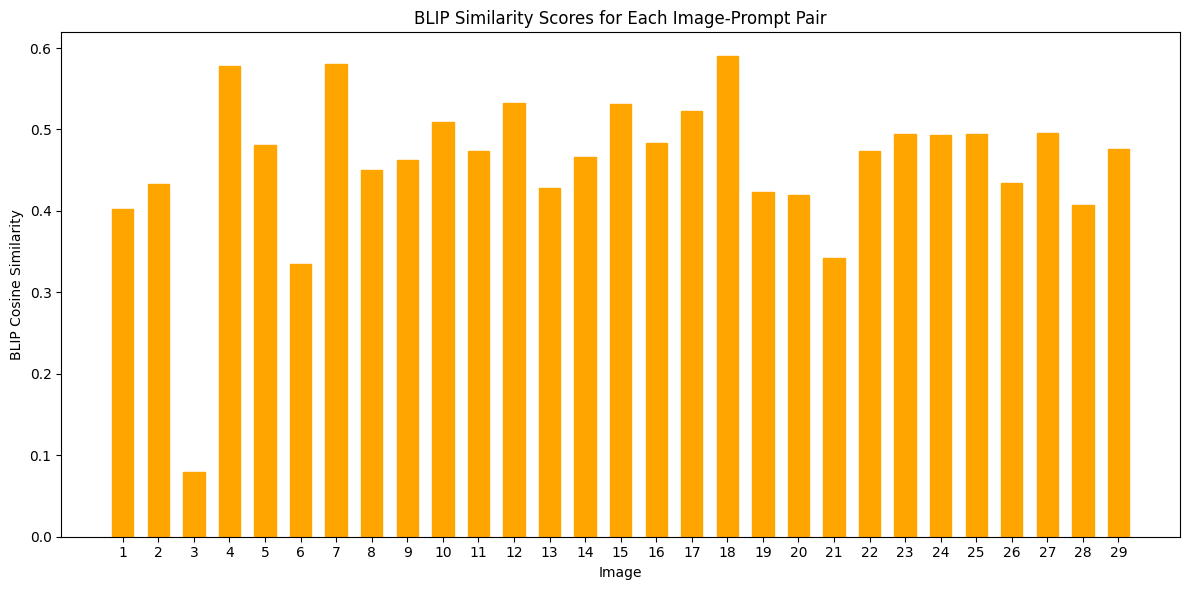

In [28]:
# --- Averages ---
avg_clip = round(np.mean(clip_scores), 4)
avg_blip = round(np.mean(blip_scores), 4)
print(f"\n🔥 Average CLIP Score: {avg_clip}")
print(f"🧠 Average BLIP Similarity Score: {avg_blip}")

# --- Bar Chart: CLIP ---
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(clip_scores)), clip_scores, width=0.6)
for bar, score in zip(bars, clip_scores):
    if score < 10:
        bar.set_color('red')
    elif score < 15:
        bar.set_color('orange')
    elif score < 20:
        bar.set_color('yellow')
    else:
        bar.set_color('green')
ax.set_xticks(range(len(clip_scores)))
ax.set_xticklabels([f'{i+1}' for i in range(len(clip_scores))], rotation=0)
ax.set_ylabel('CLIP Score')
ax.set_xlabel('Image')
ax.set_title('CLIP Scores for Each Image-Prompt Pair')
plt.tight_layout()
plt.show()

# --- Bar Chart: BLIP ---
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(blip_scores)), blip_scores, width=0.6)
for bar, score in zip(bars, blip_scores):
    if score < 0.1:
        bar.set_color('orange')
    elif score < 0.3:
        bar.set_color('orange')
    else:
        bar.set_color('orange')
ax.set_xticks(range(len(blip_scores)))
ax.set_xticklabels([f'{i+1}' for i in range(len(blip_scores))], rotation=0)
ax.set_ylabel('BLIP Cosine Similarity')
ax.set_xlabel('Image')
ax.set_title('BLIP Similarity Scores for Each Image-Prompt Pair')
plt.tight_layout()
plt.show()